Mounted at /content/drive
+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(8,[0,1,6,7],[3.0...|    0|       0.0|[0.99186991869918...|
|(8,[1,5,6,7],[73....|    0|       0.0|[0.99186991869918...|
|(8,[1,5,6,7],[117...|    0|       1.0|[0.19230769230769...|
|(8,[1,5,6,7],[145...|    1|       1.0|           [0.0,1.0]|
|[0.0,78.0,88.0,29...|    0|       0.0|[0.86170212765957...|
|[0.0,91.0,68.0,32...|    0|       0.0|[0.86170212765957...|
|[0.0,95.0,64.0,39...|    0|       0.0|[0.86170212765957...|
|[0.0,100.0,88.0,6...|    0|       1.0|[0.19230769230769...|
|[0.0,104.0,64.0,2...|    0|       0.0|[0.99186991869918...|
|[0.0,104.0,64.0,3...|    1|       0.0|[0.86170212765957...|
+--------------------+-----+----------+--------------------+
only showing top 10 rows

Accuracy: 0.7967
Precision: 0.7954
Recall: 0.7967
AUC (ROC): 0.7952

Feature Importances:
preg

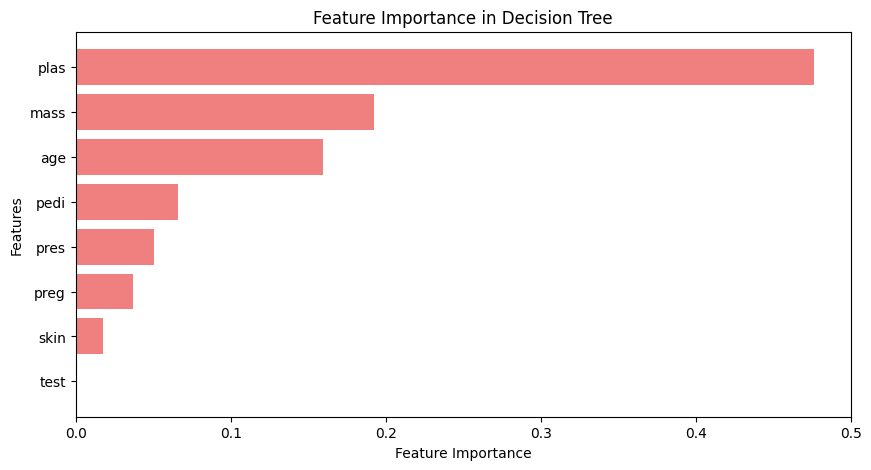

In [3]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Initialize Spark session
spark = SparkSession.builder.appName("pima").getOrCreate()

# Load dataset from Google Drive
file_path = "/content/drive/MyDrive/BDA/Dataset/pima.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Data Preprocessing: Convert feature columns into a single vector
feature_columns = df.columns[:-1]  # all columns except 'class'
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df).select("features", col("class").alias("label"))

# Split data into training (80%) and testing (20%) sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Initialize and train Decision Tree model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5, seed=42)
dt_model = dt.fit(train_df)

# Make predictions on the test set
predictions = dt_model.transform(test_df)
predictions.select("features", "label", "prediction", "probability").show(10)

# Model Evaluation: Accuracy, Precision, Recall, AUC
accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(predictions)
precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(predictions)
recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(predictions)
auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC").evaluate(predictions)

# Print Evaluation Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC (ROC): {auc:.4f}")

# Feature Importance Analysis
feature_importances = dt_model.featureImportances.toArray()  # Convert to list

print("\nFeature Importances:")
for i, col_name in enumerate(feature_columns):
    print(f"{col_name}: {feature_importances[i]:.4f}")

# Plot Feature Importance
importances = list(zip(feature_columns, feature_importances))
importances.sort(key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 5))
plt.barh([x[0] for x in importances], [x[1] for x in importances], color='lightcoral')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Decision Tree")
plt.gca().invert_yaxis()
plt.show()

# Stop Spark session
spark.stop()
